<a href="https://colab.research.google.com/github/Mario-td/Inference-for-Hand-Gesture-Classification/blob/master/Build_Torch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load data**

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Path to the files
path = '/content/drive/My Drive/MastersThesis/Dataset'

training = pd.read_csv(path + '/TrainingSet2D.csv')
test = pd.read_csv(path + '/TestSet2D.csv')

# Data visualization
training

,Label,Sequence,j0_x,j0_y,j1_x,j1_y,j2_x,j2_y,j3_x,j3_y,j4_x,j4_y,j5_x,j5_y,j6_x,j6_y,j7_x,j7_y,j8_x,j8_y,j9_x,j9_y,j10_x,j10_y,j11_x,j11_y,j12_x,j12_y,j13_x,j13_y,j14_x,j14_y,j15_x,j15_y,j16_x,j16_y,j17_x,j17_y,j18_x,j18_y,j19_x,j19_y,j20_x,j20_y
0,0,0,0.427588,0.782585,0.487573,0.679753,0.538989,0.599772,0.564697,0.508366,0.607544,0.462663,0.453296,0.474089,0.453296,0.394108,0.453296,0.348405,0.453296,0.291276,0.410449,0.474089,0.401880,0.405534,0.401880,0.336979,0.393311,0.268424,0.367603,0.496940,0.350464,0.439811,0.350464,0.371257,0.350464,0.314128,0.341895,0.565495,0.307617,0.519792,0.299048,0.474089,0.307617,0.416960
1,0,1,0.376929,0.779590,0.444702,0.666634,0.470117,0.553678,0.487061,0.474609,0.520947,0.429427,0.368457,0.452018,0.368457,0.384245,0.359985,0.339062,0.351514,0.282585,0.326099,0.474609,0.317627,0.395540,0.300684,0.327767,0.283740,0.271289,0.292212,0.508496,0.266797,0.429427,0.249854,0.372949,0.249854,0.316471,0.275269,0.564974,0.215967,0.519792,0.207495,0.474609,0.207495,0.440723
2,0,2,0.364795,0.769401,0.416064,0.666862,0.450244,0.552930,0.467334,0.473177,0.492969,0.427604,0.347705,0.450391,0.339160,0.393424,0.330615,0.336458,0.313525,0.279492,0.304980,0.473177,0.296436,0.393424,0.270801,0.336458,0.253711,0.268099,0.270801,0.507357,0.236621,0.438997,0.219531,0.382031,0.210986,0.325065,0.253711,0.564323,0.202441,0.530143,0.185352,0.484570,0.176807,0.438997
3,0,3,0.349219,0.747461,0.400049,0.657096,0.442407,0.555436,0.467822,0.476367,0.484766,0.408594,0.340747,0.465072,0.323804,0.386003,0.306860,0.329525,0.289917,0.284342,0.289917,0.476367,0.264502,0.397298,0.247559,0.329525,0.222144,0.273047,0.256030,0.510254,0.222144,0.431185,0.205200,0.374707,0.196729,0.329525,0.239087,0.566732,0.188257,0.532845,0.171313,0.498958,0.162842,0.453776
4,0,4,0.342187,0.750000,0.393750,0.646875,0.428125,0.555208,0.436719,0.463542,0.453906,0.406250,0.316406,0.463542,0.299219,0.383333,0.282031,0.326042,0.264844,0.280208,0.273438,0.475000,0.247656,0.394792,0.221875,0.326042,0.196094,0.280208,0.239063,0.509375,0.204687,0.440625,0.178906,0.383333,0.161719,0.326042,0.221875,0.566667,0.178906,0.532292,0.153125,0.497917,0.135937,0.452083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111547,4,27,0.594629,0.701237,0.634863,0.687826,0.670068,0.654297,0.685156,0.620768,0.675098,0.587240,0.624805,0.526888,0.619775,0.493359,0.624805,0.466536,0.609717,0.439714,0.584570,0.526888,0.579541,0.493359,0.569482,0.479948,0.559424,0.446419,0.564453,0.547005,0.544336,0.526888,0.534277,0.506771,0.524219,0.506771,0.529248,0.587240,0.524219,0.560417,0.519189,0.560417,0.519189,0.560417
111548,4,28,0.605029,0.717969,0.634570,0.686458,0.670020,0.662826,0.681836,0.623437,0.687744,0.599805,0.616846,0.536784,0.616846,0.481641,0.616846,0.450130,0.610938,0.410742,0.581396,0.528906,0.569580,0.473763,0.557764,0.434375,0.551855,0.402865,0.551855,0.552539,0.534131,0.513151,0.522314,0.489518,0.504590,0.458008,0.528223,0.584049,0.516406,0.568294,0.498682,0.552539,0.492773,0.528906
111549,4,29,0.602441,0.715365,0.631494,0.699870,0.666357,0.668880,0.677979,0.637891,0.689600,0.606901,0.619873,0.537174,0.619873,0.475195,0.619873,0.444206,0.614062,0.405469,0.579199,0.529427,0.567578,0.475195,0.555957,0.428711,0.550146,0.397721,0.550146,0.552669,0.532715,0.513932,0.515283,0.475195,0.503662,0.451953,0.526904,0.583659,0.509473,0.560417,0.492041,0.544922,0.486230,0.521680
111550,4,30,0.601611,0.717057,0.630786,0.693717,0.665796,0.670378,0.683301,0.639258,0.689136,0.608138,0.619116,0.538118,0.619116,0.491439,0.619116,0.444759,0.613281,0.405859,0.578271,0.530339,0.572437,0.475879,0.560767,0.436979,0.549097,0.398079,0.549097,0.553678,0.537427,0.506999,0.525757,0.475879,0.508252,0.444759,0.525757,0.592578,0.508252,0.561458,0.490747,0.538118,0.479077,0.514779


In [4]:
n_classes = len(training['Label'].unique())

In [5]:
# Get the number of frames per sample
t_steps = max(training['Sequence']) + 1
t_steps

32

In [6]:
# Get the labels
Y_train = np.array(training['Label'][0::t_steps][:], dtype=np.int32)
Y_test = np.array(test['Label'][0::t_steps][:], dtype=np.int32)

In [7]:
# Get the data
X_train = pd.DataFrame.to_numpy(training[training.columns[2:]])
X_test = pd.DataFrame.to_numpy(test[test.columns[2:]])
# Split into the number of samples
X_train = np.array(np.split(X_train, Y_train.size))
X_test = np.array(np.split(X_test, Y_test.size))

In [8]:
# Split into train, validation 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [9]:
print('X_train shape '+ str(X_train.shape))
print('X_val shape '+ str(X_val.shape))

X_train shape (3137, 32, 42)
X_val shape (349, 32, 42)


# **Data augmentation**

In [10]:
def dataAugmentation(X_, Y, c):
    X = X_[Y == c]
    # Duplicate the samples by inverting the order of the sequence in time
    X_inv_t = [X[i][::-1] for i in range(len(X))]
    X = np.append(X, X_inv_t, 0)
    # Duplicate the samples by inverting the x coordinate
    # with respect to the y axis (mirroring)
    X_inv_pos = []
    for k in range(len(X)):
        Xj = []
        for j in range(len(X[k])):
            Xi = []
            for i in range(len(X[k][j])):
                if i % 3 == 0:
                    Xi.append(abs(X[k][j][i] - 1))
                else:
                    Xi.append(X[k][j][i])
            Xj.append(Xi)
        X_inv_pos.append(Xj)
    X = np.append(X, X_inv_pos, 0)
    X_ = np.append(X_[Y != c], X, 0)
    Y = np.append(Y[Y != c], np.ones(len(X)) * c)
    return X_, Y

In [11]:
# Duplicate samples of all classes in training, validation and test sets
# separately to avoid overfitting mixing samples
for c in range(n_classes):
    X_train, Y_train = dataAugmentation(X_train, Y_train, c)
    X_val, Y_val = dataAugmentation(X_val, Y_val, c)
    X_test, Y_test = dataAugmentation(X_test, Y_test, c)

In [12]:
# Prints the number of samples per class in the training and test set
for i in range(n_classes):
    print('train samples %d: ' % i + str(np.count_nonzero(Y_train == i)))
print('----------------------')
for i in range(n_classes):
    print('val samples %d: ' % i + str(np.count_nonzero(Y_val == i)))
print('----------------------')
for i in range(n_classes):
    print('test samples %d: ' % i + str(np.count_nonzero(Y_test == i)))

train samples 0: 2524
train samples 1: 2432
train samples 2: 2480
train samples 3: 2464
train samples 4: 2648
----------------------
val samples 0: 324
val samples 1: 276
val samples 2: 268
val samples 3: 224
val samples 4: 304
----------------------
test samples 0: 288
test samples 1: 284
test samples 2: 300
test samples 3: 288
test samples 4: 288


In [13]:
# Convert to tensor
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test) 
Y_train = torch.from_numpy(Y_train)
Y_val = torch.from_numpy(Y_val)
Y_test = torch.from_numpy(Y_test)

In [14]:
X_train = X_train.transpose(1,2)
X_val = X_val.transpose(1,2)
X_test = X_test.transpose(1,2)

# **Build Neural Network**

In [15]:
n_inputs = X_train[0].shape[0]
n_filters_conv1 = 64
n_filters_conv2 = 64
hidden_lstm = 200
n_fc = 5600

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv1d(in_channels=n_inputs, out_channels=n_filters_conv1, kernel_size=3, stride=1)
      self.conv2 = nn.Conv1d(in_channels=n_filters_conv1, out_channels=n_filters_conv2, kernel_size=3, stride=1)
      self.flatten = nn.Flatten(start_dim=1, end_dim=2)
      self.lstm1 = torch.nn.LSTM(
            input_size= n_filters_conv2,
            hidden_size=hidden_lstm,
            batch_first=True,
            num_layers=1)
      self.lin = nn.Linear(n_fc, n_classes)
      self.dropout = nn.Dropout(0.1)
      self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = x.view(-1, 28, n_filters_conv2)
      x, _ = self.lstm1(x)
      x = x.contiguous().view(-1, n_fc)
      x = self.lin(x)
      x = self.dropout(x)
      x = self.softmax(x)
      return x

net = Net()
print(net)

Net(
  (conv1): Conv1d(42, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=2)
  (lstm1): LSTM(64, 200, batch_first=True)
  (lin): Linear(in_features=5600, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [16]:
learning_rate = 0.0011
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
crossentropy = nn.CrossEntropyLoss()

In [17]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 1064,
          'shuffle': True,
          'num_workers': 6}

In [18]:
train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], Y_train[i]])
val_data = []
for i in range(len(X_val)):
   val_data.append([X_val[i], Y_val[i]])
test_data = []
for i in range(len(X_test)):
   test_data.append([X_test[i], Y_test[i]])

trainloader = torch.utils.data.DataLoader(train_data, **params)
validationloader = torch.utils.data.DataLoader(val_data,  **params)
testloader = torch.utils.data.DataLoader(test_data, batch_size=test.shape[0])

In [19]:
for epoch in range(150):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        local_batch, local_labels = data
        # Transfer to GPU
        # local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        # Switch model to training mode, clear gradient accumulators
        net.train()
        optimizer.zero_grad()
        # Forward + Backward + Optimize
        outputs = net(local_batch.float())
        loss = crossentropy(outputs, local_labels.long())
        loss.backward()
        optimizer.step()

        # Calculate accuracy of predictions in the current batch
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        correct += (predicted == local_labels.long()).sum().item()
    # Print statistics
    print(
        'Epoch %d:\nloss: %.3f, accuracy: %.3f' %
        (epoch + 1, loss.item(), 100 * correct/total))
    correct = 0
    total = 0
    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validationloader:
            # Transfer to GPU
            # local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            net.eval()
            outputs = net(local_batch.float())
            loss = crossentropy(outputs, local_labels.long())
            # Calculate accuracy of predictions in the current batch
            _, predicted = torch.max(outputs.data, 1)
            total += local_labels.size(0)
            correct += (predicted == local_labels.long()).sum().item()
        print(
            'val_loss: %.3f, val_accuracy: %.3f' %
            (loss.item(), 100 * correct/total))
    print('-------------------------------------')
print('Finished Training')

Epoch 1:
loss: 1.537, accuracy: 24.657
val_loss: 1.515, val_accuracy: 45.272
-------------------------------------
Epoch 2:
loss: 1.367, accuracy: 43.840
val_loss: 1.025, val_accuracy: 56.948
-------------------------------------
Epoch 3:
loss: 1.156, accuracy: 45.067
val_loss: 1.043, val_accuracy: 58.166
-------------------------------------
Epoch 4:
loss: 0.936, accuracy: 55.969
val_loss: 0.826, val_accuracy: 66.261
-------------------------------------
Epoch 5:
loss: 0.809, accuracy: 60.751
val_loss: 0.737, val_accuracy: 66.046
-------------------------------------
Epoch 6:
loss: 0.797, accuracy: 64.600
val_loss: 0.683, val_accuracy: 67.837
-------------------------------------
Epoch 7:
loss: 0.770, accuracy: 65.787
val_loss: 0.596, val_accuracy: 71.848
-------------------------------------
Epoch 8:
loss: 0.675, accuracy: 68.911
val_loss: 0.600, val_accuracy: 72.636
-------------------------------------
Epoch 9:
loss: 0.617, accuracy: 72.235
val_loss: 0.500, val_accuracy: 78.940
---

# **Test model with new data**

In [59]:
correct = 0
total = 0
with torch.set_grad_enabled(False):
    for local_batch, local_labels in testloader:
        # Transfer to GPU
        # local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        net.eval();
        outputs = net(local_batch.float())
        # calculate accuracy of predictions in the current batch
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        correct += (predicted == local_labels.long()).sum().item()
        print('Test accuracy: %.3f' %
                (100 * correct / total))

Test accuracy: 96.754


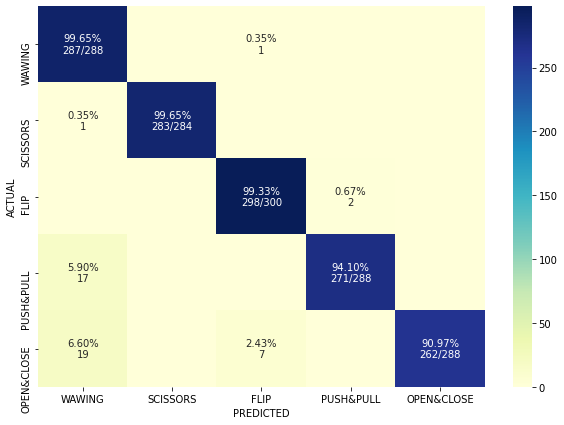

In [63]:
# Label of the classes
labels = [    
    'WAWING',
    'SCISSORS',
    'FLIP',
    'PUSH&PULL',
    'OPEN&CLOSE'
] 

cm = confusion_matrix(local_labels, predicted)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.2f%%\n%d' % (p, c)
cm = pd.DataFrame(cm, index=labels, columns=labels)
cm.index.name = 'ACTUAL'
cm.columns.name = 'PREDICTED'
plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=annot, fmt='', cmap="YlGnBu")

# **Save model**

In [64]:
# Load a sample image
example_image, example_label = next(iter(trainloader))
# Run the tracing
traced_script_module = torch.jit.trace(net, example_image.float())
# Save the converted model
traced_script_module.save('/content/drive/My Drive/MastersThesis/Pytorch/model.pt')